## Advanced Lane Finding
[![Udacity - Self-Driving Car NanoDegree](https://s3.amazonaws.com/udacity-sdc/github/shield-carnd.svg)](http://www.udacity.com/drive)

The Project
---

The goals / steps of this project are the following:

* Compute the camera calibration matrix and distortion coefficients given a set of chessboard images.
* Apply a distortion correction to raw images.
* Use color transforms, gradients, etc., to create a thresholded binary image.
* Apply a perspective transform to rectify binary image ("birds-eye view").
* Detect lane pixels and fit to find the lane boundary.
* Determine the curvature of the lane and vehicle position with respect to center.
* Warp the detected lane boundaries back onto the original image.
* Output visual display of the lane boundaries and numerical estimation of lane curvature and vehicle position.


### LIbrary Code (Utils class, Camera class, Binarizer class, Detector class)

In [1]:
import cv2
import glob
import numpy as np
import os
import random
import pickle
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

class Utils:
    @staticmethod
    def visualizeBeforeAfter(beforeImg, afterImg, beforeTitle, afterTitle, beforeGray=False, afterGray=False, beforeBinary=False, afterBinary=False):
        # Visualize undistortion
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
        
        if (beforeBinary):
            beforeImg = np.dstack((beforeImg, beforeImg, beforeImg))*255
        
        if (afterBinary):
            afterImg = np.dstack((afterImg, afterImg, afterImg))*255
        
        if (beforeGray):
            ax1.imshow(beforeImg, cmap='gray')
        else:
            ax1.imshow(beforeImg)
        
        ax1.set_title(beforeTitle, fontsize=30)

        if (afterGray):
            ax2.imshow(afterImg, cmap='gray')
        else:
            ax2.imshow(afterImg)
        
        ax2.set_title(afterTitle, fontsize=30)
        
        return

#### Camera Class

In [2]:
class Camera:
    """Detect and apply distortion and perspective correction"""
    def __init__(self):
        self.camera_cal_images = None
        self.ret = None
        self.mtx = None
        self.dist = None
        self.rvecs = None
        self.tvecs = None

        # Arrays to store object points and image points from all the images.
        self.objpoints = [] # 3d points in real world space
        self.imgpoints = [] # 2d points in image plane.

    def read_calibration_images(self):
        # Make a list of calibration images
        self.camera_cal_images = glob.glob('./camera_cal/cal*.jpg')
        return self.camera_cal_images


    def pre_calibrate(self):
        # prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
        objp = np.zeros((6*9,3), np.float32)
        objp[:,:2] = np.mgrid[0:9, 0:6].T.reshape(-1,2)

        # Step through the list and search for chessboard corners
        for idx, fname in enumerate(self.camera_cal_images):
            img = cv2.imread(fname)
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

            # Find the chessboard corners
            ret, corners = cv2.findChessboardCorners(gray, (9,6), None)

            # If found, add object points, image points
            if ret == True:
                self.objpoints.append(objp)
                self.imgpoints.append(corners)

                # Draw and display the corners
                cv2.drawChessboardCorners(img, (9,6), corners, ret)
                #write_name = 'corners_found'+str(idx)+'.jpg'
                #cv2.imwrite(write_name, img)

        #         cv2.imshow('img', img)
        #         cv2.waitKey(500)

    def calibrate(self, img):
        # Test undistortion on an image
        # img = cv2.imread('calibration_wide/test_image.jpg')
        # img = cv2.imread('camera_cal/calibration2.jpg')
        img_size = (img.shape[1], img.shape[0])

        # Do camera calibration given object points and image points
        self.ret, self.mtx, self.dist, self.rvecs, self.tvecs = cv2.calibrateCamera(self.objpoints, self.imgpoints, img_size, None, None)
        return

    def undistort(self, img):
        dst = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        # cv2.imwrite('output_images/test_undist.jpg',dst)
        return dst

    def dump_pickle_file(self):
        # Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
        dist_pickle = {}
        dist_pickle["mtx"] = self.mtx
        dist_pickle["dist"] = self.dist
        pickle.dump( dist_pickle, open( "wide_dist_pickle.p", "wb" ) )

    def get_perspective(self, image, source_points, dest_points=None, offset_x=300, offset_y=0):
        """Detect perspective from camera"""
        if dest_points is None:
            dest_points = np.float32([(offset_x, offset_y), (image.shape[1] - offset_x, offset_y),
                                      (image.shape[1] - offset_x, image.shape[0]), (offset_x, image.shape[0])])

        perspective_source_points = source_points
        perspective_dest_points = dest_points
        self.perspective_matrix = cv2.getPerspectiveTransform(source_points, dest_points)
        self.inverse_perspective_matrix = cv2.getPerspectiveTransform(dest_points, source_points)
        return (self.perspective_matrix, self.inverse_perspective_matrix)

    # def save(self, filename=os.path.join(base_dir, "camera.p")):
    #     """Save parameters from Camera class in file"""
    #     pickle.dump(vars(self), open(filename, "wb"))


    def to_perspective(self, top_down_image):
        """Convert an image from top down back to perspective using inverse perspective matrix"""
        return cv2.warpPerspective(top_down_image, self.inverse_perspective_matrix,
                                   (top_down_image.shape[1], top_down_image.shape[0]))

    def reverse_pespective_warped_and_overlay_on_image(self, detector, warped, img):
        # Create an image to draw the lines on
        warp_zero = np.zeros_like(warped).astype(np.uint8)
        color_warp = np.dstack((warp_zero, warp_zero, warp_zero))

        # Recast the x and y points into usable format for cv2.fillPoly()
        pts_left = np.array([np.transpose(np.vstack([detector.left_fitx, detector.ploty]))])
        pts_right = np.array([np.flipud(np.transpose(np.vstack([detector.right_fitx, detector.ploty])))])
        pts = np.hstack((pts_left, pts_right))

        # Draw the lane onto the warped blank image
        cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))

        # Warp the blank back to original image space using inverse perspective matrix (Minv)
        newwarp = cv2.warpPerspective(color_warp, self.inverse_perspective_matrix, (img.shape[1], img.shape[0])) 
        # Combine the result with the original image
        result = cv2.addWeighted(img, 1, newwarp, 0.3, 0)
        return result
    

    def detect_perspective(self, image, source_points = [(581, 461), (703, 461), (1064, 692), (245, 692)]):
        """Detect camera perspective."""
    #     print("detect perspective")
        
        (self.perspective_matrix, self.inverse_perspective_matrix) = self.get_perspective(image, source_points=np.float32(source_points))
        warped = cv2.warpPerspective(image, self.perspective_matrix,
                                       (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        return warped


#### Binarizer class

In [3]:
class Binarizer:
    # Define a function that applies Sobel x or y, 
    # then takes an absolute value and applies a threshold.
    # Note: calling your function with orient='x', thresh_min=5, thresh_max=100
    # should produce output like the example image shown above this quiz.
    def abs_sobel_thresh(self, img, orient='x', sobel_kernel=3, thresh=(0, 255)):
        thresh_min = thresh[0]
        thresh_max = thresh[1]

        # Convert to grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Apply x or y gradient with the OpenCV Sobel() function
        # and take the absolute value
        if orient == 'x':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel))
        if orient == 'y':
            abs_sobel = np.absolute(cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel))
        # Rescale back to 8 bit integer
        scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
        # Create a copy and apply the threshold
        binary_output = np.zeros_like(scaled_sobel)
        # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
        binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1

        # Return the result
        return binary_output

    # Run the function
    # grad_binary = abs_sobel_thresh(image, orient='x', thresh_min=20, thresh_max=100)

    # Define a function that applies Sobel x and y, 
    # then computes the direction of the gradient
    # and applies a threshold.
    def dir_threshold(self, img, sobel_kernel=3, thresh=(0, np.pi/2)):
        # Grayscale
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Calculate the x and y gradients
        sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Take the absolute value of the gradient direction, 
        # apply a threshold, and create a binary image result
        absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
        # plt.hist(absgraddir, 10)
        binary_output =  np.zeros_like(absgraddir)
        binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1

        return binary_output

    # Run the function
    # dir_binary = dir_threshold(image, sobel_kernel=15, thresh=(0.7, 1.3))

    # Define a function that applies Sobel x and y, 
    # then computes the magnitude of the gradient
    # and applies a threshold
    def mag_thresh(self, img, sobel_kernel=3, mag_thresh=(0, 255)):
#         # Convert to HSL color space and separate the V channel
        hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
        l_channel = hsv[:,:,1]
        s_channel = hsv[:,:,2]

#         # Threshold color channel
#         s_binary = np.zeros_like(s_channel)
#         s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1

#         gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        # Take both Sobel x and y gradients
        sobelx = cv2.Sobel(s_channel, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
        sobely = cv2.Sobel(s_channel, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
        # Calculate the gradient magnitude
        gradmag = np.sqrt(sobelx**2 + sobely**2)
        # print (gradmag)
        # Rescale to 8 bit
        scale_factor = np.max(gradmag)/255 
        gradmag = (gradmag/scale_factor).astype(np.uint8) 
        # Create a binary image of ones where threshold is met, zeros otherwise
        binary_output = np.zeros_like(gradmag)
        binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1

        return binary_output

    # Run the function
    # mag_binary = mag_thresh(image, sobel_kernel=3, mag_thresh=(30, 100))

    # Edit this function to create your own pipeline.
    def binarize(self, img, gradx_thresh=(60, 210), grady_thresh=(60, 210), mag_thresh=(30, 100), dir_thresh=(0.7, 1.3)):
        img = np.copy(img)
        # Choose a Sobel kernel size
        ksize = 3 # Choose a larger odd number to smooth gradient measurements

        # Apply each of the thresholding functions
        gradx = self.abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=gradx_thresh)
        grady = self.abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=grady_thresh)
        mag_binary = self.mag_thresh(img, sobel_kernel=ksize, mag_thresh=mag_thresh)
        dir_binary = self.dir_threshold(img, sobel_kernel=15, thresh=dir_thresh)



#         # Convert to HSL color space and separate the V channel
#         hsv = cv2.cvtColor(img, cv2.COLOR_RGB2HLS).astype(np.float)
#         l_channel = hsv[:,:,1]
#         s_channel = hsv[:,:,2]
#         # Sobel x
#         sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) # Take the derivative in x
#         abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
#         scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))

#         # Threshold x gradient
#         sxbinary = np.zeros_like(scaled_sobel)
#         sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1

#         # Threshold color channel
#         s_binary = np.zeros_like(s_channel)
#         s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
        # Stack each channel
        # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
        # be beneficial to replace this channel with something else.
        color_binary = np.dstack(( np.zeros_like(dir_binary), gradx, grady))
        color_binary2 = np.dstack(( np.zeros_like(dir_binary), mag_binary, dir_binary))
        return gradx, grady, mag_binary, dir_binary, color_binary, color_binary2

    def get_combined_binary(self, gradx, grady, mag_binary, dir_binary):
        # Combine the two binary thresholds
#         combined_binary = np.zeros_like(sxbinary)
#         combined_binary[(s_binary == 1) | (sxbinary == 1)] = 1
        combined = np.zeros_like(dir_binary)
        combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
        return combined


#### Detector Class

In [4]:
class Detector:
    def __init__(self):
        self.window_width = 50 
        self.window_height = 80 # Break image into 9 vertical layers since image height is 720
        self.margin = 100 # How much to slide left and right for searching
        self.prev_left_fitx = None
        self.prev_right_fitx = None
        self.left_fitx = None
        self.right_fitx = None
        self.ploty = None
        self.detected = False
        # x values of the last n fits of the line
        self.recent_left_fits = [] 
        self.recent_right_fits = [] 
        # Number of history records
        self.num_history = 10
        # Number of consecutive no good detection, which should trigger reset
        self.num_no_update = 5
        # Max allowed percetage of deviation from avg in a single detection
        self.max_deviation_percentage = 0.3
        # No update counters
        self.l_cnt = 0
        self.r_cnt = 0
        
    def window_mask(self, width, height, img_ref, center,level):
        output = np.zeros_like(img_ref)
        output[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
        return output

    def sliding_window_method_to_fit_2nd_order_polynomial(self, warped):
        binary_warped = warped
        # Assuming you have created a warped binary image called "binary_warped"
        # Take a histogram of the bottom half of the image
        histogram = np.sum(binary_warped[int(binary_warped.shape[0]/2):,:], axis=0)
        # Create an output image to draw on and  visualize the result
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Find the peak of the left and right halves of the histogram
        # These will be the starting point for the left and right lines
        midpoint = np.int(histogram.shape[0]/2)
        leftx_base = np.argmax(histogram[:midpoint])
        rightx_base = np.argmax(histogram[midpoint:]) + midpoint

        # Choose the number of sliding windows
        nwindows = 9
        # Set height of windows
        window_height = np.int(binary_warped.shape[0]/nwindows)
        # Identify the x and y positions of all nonzero pixels in the image
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Current positions to be updated for each window
        leftx_current = leftx_base
        rightx_current = rightx_base
        # Set the width of the windows +/- margin
        margin = 100
        # Set minimum number of pixels found to recenter window
        minpix = 75
        # Create empty lists to receive left and right lane pixel indices
        left_lane_inds = []
        right_lane_inds = []

        # Step through the windows one by one
        for window in range(nwindows):
            # Identify window boundaries in x and y (and right and left)
            win_y_low = binary_warped.shape[0] - (window+1)*window_height
            win_y_high = binary_warped.shape[0] - window*window_height
            win_xleft_low = leftx_current - margin
            win_xleft_high = leftx_current + margin
            win_xright_low = rightx_current - margin
            win_xright_high = rightx_current + margin
            # Draw the windows on the visualization image
            cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
            cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
            # Identify the nonzero pixels in x and y within the window
            good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
            good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
            # Append these indices to the lists
            left_lane_inds.append(good_left_inds)
            right_lane_inds.append(good_right_inds)
            # If you found > minpix pixels, recenter next window on their mean position
            if len(good_left_inds) > minpix:
                leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
            if len(good_right_inds) > minpix:        
                rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

        # Concatenate the arrays of indices
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)

        # Extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds] 

        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        
        self.detected = True


        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return out_img

    def iterative_fit_calculation(self, binary_warped):
        out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
        # Assume you now have a new warped binary image 
        # from the next frame of video (also called "binary_warped")
        # It's now much easier to find line pixels!
        nonzero = binary_warped.nonzero()
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        margin = 100
        left_lane_inds = ((nonzerox > (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] - margin)) & (nonzerox < (self.left_fit[0]*(nonzeroy**2) + self.left_fit[1]*nonzeroy + self.left_fit[2] + margin))) 
        right_lane_inds = ((nonzerox > (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] - margin)) & (nonzerox < (self.right_fit[0]*(nonzeroy**2) + self.right_fit[1]*nonzeroy + self.right_fit[2] + margin)))  

        # Again, extract left and right line pixel positions
        leftx = nonzerox[left_lane_inds]
        lefty = nonzeroy[left_lane_inds] 
        rightx = nonzerox[right_lane_inds]
        righty = nonzeroy[right_lane_inds]
        # Fit a second order polynomial to each
        self.left_fit = np.polyfit(lefty, leftx, 2)
        self.right_fit = np.polyfit(righty, rightx, 2)
        # Generate x and y values for plotting
        self.ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        self.left_fitx = self.left_fit[0]*self.ploty**2 + self.left_fit[1]*self.ploty + self.left_fit[2]
        self.right_fitx = self.right_fit[0]*self.ploty**2 + self.right_fit[1]*self.ploty + self.right_fit[2]

        out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
        out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
        return out_img

    def smooth(self, prev, curr, coeficient = 0.4):
            '''
             exponential smoothing
            :param prev: old value
            :param curr: new value
            :param coeficient: smoothing coef.
            :return:
            '''
            return curr*coeficient + prev*(1-coeficient)

    def calculate_lane_polynomial_fits(self, binary_warped, image):
        if (self.detected == False):
            result = self.sliding_window_method_to_fit_2nd_order_polynomial(binary_warped)
        else:
            self.prev_left_fitx = self.left_fitx
            self.prev_right_fitx = self.right_fitx
            result = self.iterative_fit_calculation(binary_warped)
            self.left_fitx = self.smooth(self.prev_left_fitx, self.left_fitx, coeficient = 0.2)
            self.right_fitx = self.smooth(self.prev_right_fitx, self.right_fitx, coeficient = 0.2)
            self.fit_sanity_check()
#             self.export_troublesome_image(image)
#             self.export_troublesome_image(np.dstack((binary_warped, binary_warped, binary_warped))*255)
        left_curverad, right_curverad, off_center = self.curvature(binary_warped, image)
        return result, left_curverad, right_curverad, off_center
    
    def fit_sanity_check(self):
        """
        - Current detected within n% of best average of past.
        - TODO: Distance between left/right lane lines.
        If yes to all above, update best records. 
        If no to any of above, keep using best records. 
        """
        l_fit = self.left_fitx
        r_fit = self.right_fitx

        # Start of detection, fill history
        if len(self.recent_left_fits)<self.num_history:
            self.recent_left_fits.append(self.left_fitx)
        else:
            l_avg = np.mean(np.array(self.recent_left_fits), axis=0)
            l_delta = np.abs((l_fit - l_avg)/l_avg) < self.max_deviation_percentage
            if l_delta.all():
#                 print("l updated.")
                self.recent_left_fits.pop(0)
                self.recent_left_fits.append(self.left_fitx)
                self.l_cnt = 0
            else:
#                 print("l uses avg.")
#                 l_fit = l_avg
                l_fit = self.recent_left_fits[-1]
                self.l_cnt += 1
                if self.l_cnt > self.num_no_update:
#                     print("l reset.")
                    self.detected = False 
                    self.recent_left_fits = []
                    self.l_cnt = 0

        if len(self.recent_right_fits)<self.num_history:
            self.recent_right_fits.append(self.right_fitx)
        else:
            r_avg = np.mean(np.array(self.recent_right_fits), axis=0)
            r_delta = np.abs((r_fit - r_avg)/r_avg) < self.max_deviation_percentage
            if r_delta.all():
#                 print("r updated.")
                self.recent_right_fits.pop(0)
                self.recent_right_fits.append(self.right_fitx)
                self.r_cnt = 0
            else:
#                 print("r uses avg.")
#                 r_fit = r_avg
                r_fit = self.recent_right_fits[-1]
                self.r_cnt += 1
                if self.r_cnt > self.num_no_update:
#                     print("r reset.")
                    self.detected = False 
                    self.recent_right_fits = []
                    self.r_cnt = 0

        # Update to use corrected l/r_fit
        self.left_fitx = l_fit
        self.right_fitx = r_fit
        return self.detected

    def export_troublesome_image(self, img):
        if (self.l_cnt > 0 or self.r_cnt > 0):
            # found problematic image - cannot find the line at all, save it for later analysis
            fname = str(random.randint(0, 1000000)) + ".jpg"
            outImg = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
            cv2.imwrite(fname, outImg)
            return img
    
    def curvature(self, binary_warped, img):
        ym_per_pix = 30/720 # Assuming 30 meters per pixel in y dimenstion
#         image_size = (img.shape[1], img.shape[0])
#         left_c = self.left_fitx[0] * image_size[0] ** 2 + self.left_fitx[1] * image_size[0] + self.left_fitx[2]
#         right_c = self.right_fitx[0] * image_size[0] ** 2 + self.right_fitx[1] * image_size[0] + self.right_fitx[2]
#         width = right_c - left_c
        xm_per_pix = 3.7 / 700
        
    
        ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
        leftx= self.left_fit[0]*ploty**2 + self.left_fit[1]*ploty + self.left_fit[2]
        rightx= self.right_fit[0]*ploty**2 + self.right_fit[1]*ploty + self.right_fit[2]

        y_eval = np.max(ploty) # Select the bottom line position to evaluate
        # Fit new polynomials to x,y in world space
        left_fit_cr = np.polyfit(ploty*ym_per_pix, leftx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
        # Now our radius of curvature is in meters
#         print(left_curverad, 'm')
        
        # Fit new polynomials to x,y in world space
        right_fit_cr = np.polyfit(ploty*ym_per_pix, rightx*xm_per_pix, 2)
        # Calculate the new radii of curvature
        right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
        # Now our radius of curvature is in meters
#         print(right_curverad, 'm')
        
        # Find car position as to center of lane
        leftx= self.left_fit[0]*y_eval**2 + self.left_fit[1]*y_eval + self.left_fit[2]
        rightx= self.right_fit[0]*y_eval**2 + self.right_fit[1]*y_eval + self.right_fit[2]

        off_x = 640 - (leftx + rightx)//2 
        off_center = off_x * xm_per_pix
#         print("off center = ", off_center)
        
        return left_curverad, right_curverad, off_center

### initialize objects

In [5]:

camera = Camera()
binarizer = Binarizer()
detector = Detector()

### Camera Calibration

#### 1. Briefly state how you computed the camera matrix and distortion coefficients. Provide an example of a distortion corrected calibration image.

I used OpenCV provided algorithms for finding checkboard in images, and then used functions `calibrateCamera` and `undistort`.

I start by preparing "object points", which will be the (x, y, z) coordinates of the chessboard corners in the world. Here I am assuming the chessboard is fixed on the (x, y) plane at z=0, such that the object points are the same for each calibration image.  Thus, `objp` is just a replicated array of coordinates, and `objpoints` will be appended with a copy of it every time I successfully detect all chessboard corners in a test image.  `imgpoints` will be appended with the (x, y) pixel position of each of the corners in the image plane with each successful chessboard detection.  

I then used the output `objpoints` and `imgpoints` to compute the camera calibration and distortion coefficients using the `cv2.calibrateCamera()` function.  I applied this distortion correction to the test image using the `cv2.undistort()` function and obtained this result: 


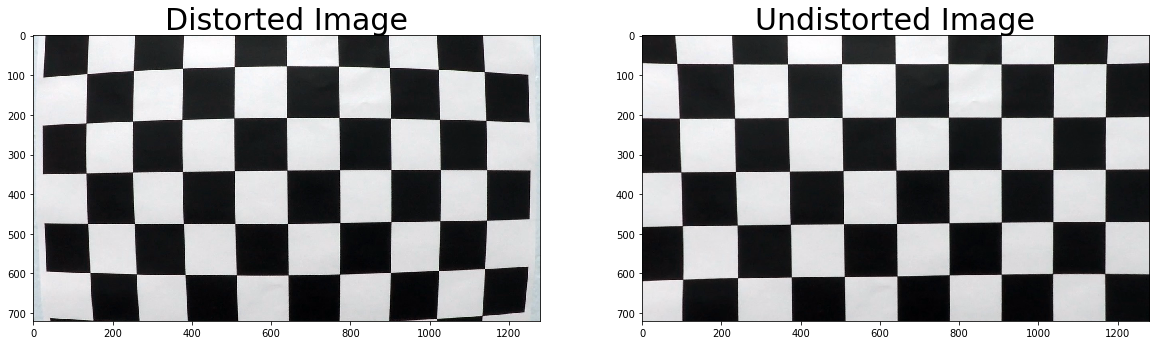

In [6]:

camera.read_calibration_images()
camera.pre_calibrate()

img = cv2.imread('./camera_cal/calibration1.jpg')
camera.calibrate(img)
dst = camera.undistort(img)

Utils.visualizeBeforeAfter(img, dst, "Distorted Image", "Undistorted Image")

### Pipeline (single images)

#### 1. Provide an example of a distortion-corrected image.
To demonstrate this step, I will describe how I apply the distortion correction to one of the test images like this one:

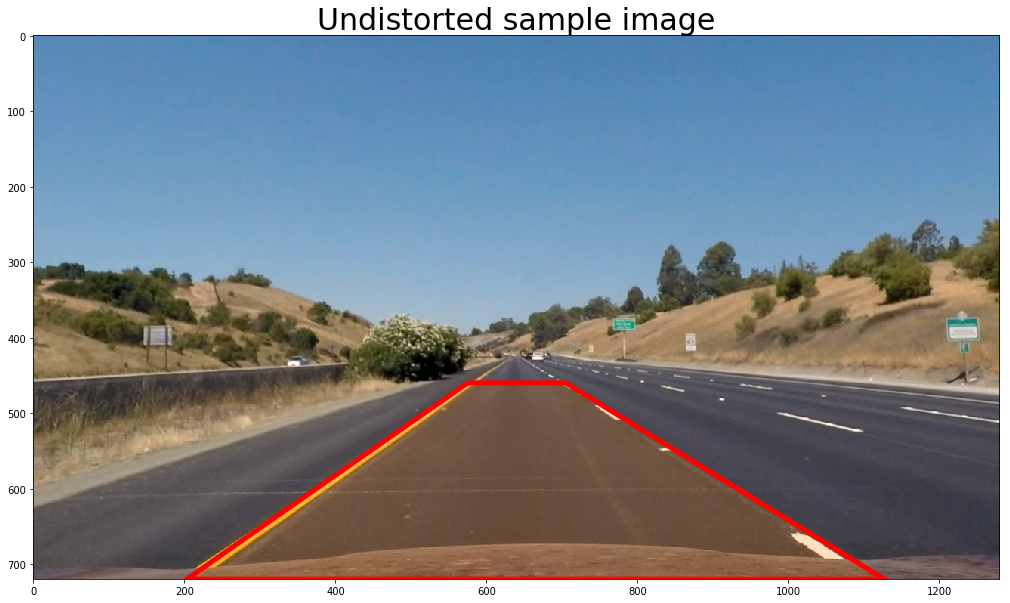

In [7]:
img = cv2.imread('./test_images/straight_lines1.jpg')
# img = cv2.imread('./test_images/straight_lines2.jpg')
# img = cv2.imread('./test_images/test1.jpg')
# img = cv2.imread('./test_images/test2.jpg')
# img = cv2.imread('./test_images/test3.jpg')
# img = cv2.imread('./test_images/test4.jpg')
# img = cv2.imread('./test_images/test5.jpg')
# img = cv2.imread('./test_images/test3.jpg')
# img = cv2.imread('./282712.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = camera.undistort(img)
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.set_title("Undistorted sample image", fontsize=30)
ax1.imshow(img)


from matplotlib.path import Path
import matplotlib.patches as patches
path = Path([(575, 460), (705, 460), (1127, 720), (203, 720), (575, 460)])
patch = patches.PathPatch(path, fc=(1,0.5,0,0.2), ec=(1,0,0,1), lw=5)
ax1.add_patch(patch)

#### 2. Describe how (and identify where in your code) you used color transforms, gradients or other methods to create a thresholded binary image.  Provide an example of a binary image result.
I used a combination of color and gradient thresholds to generate a binary image (thresholding steps in `Camera` class above in cell 4).  Here's an example of my output for this step.  (note: this is not actually from one of the test images)

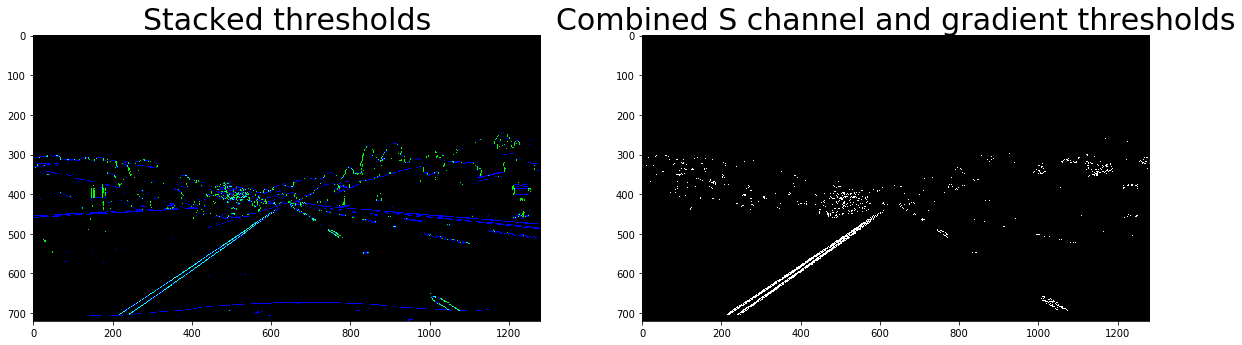

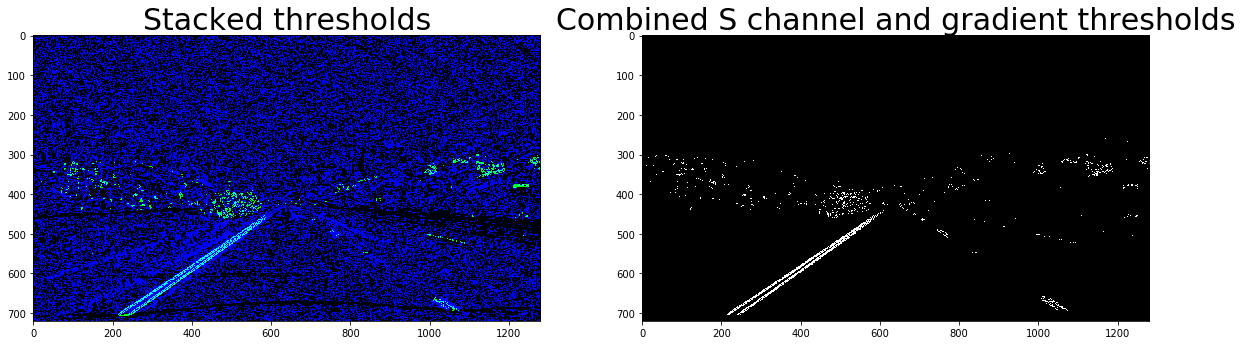

In [8]:
(gradx, grady, mag_binary, dir_binary, color_binary, color_binary2) = binarizer.binarize(img,
                                                                              gradx_thresh=(50, 150),
                                                                              grady_thresh=(50, 150),
                                                                              mag_thresh=(40, 100),
                                                                              dir_thresh=(0.7, 1.3)
                                                                                        )
combined_binary = binarizer.get_combined_binary(gradx, grady, mag_binary, dir_binary)

# Plotting thresholded images
Utils.visualizeBeforeAfter(color_binary,
                           combined_binary,
                           "Stacked thresholds",
                           "Combined S channel and gradient thresholds",
                           afterGray=True)


# Plotting thresholded images
Utils.visualizeBeforeAfter(color_binary2,
                           combined_binary,
                           "Stacked thresholds",
                           "Combined S channel and gradient thresholds",
                           afterGray=True)

#### 3. Describe how (and identify where in your code) you performed a perspective transform and provide an example of a transformed image.

The code for my perspective transform is in the `detect_perspective()` function of `Camera class`.  The `detect_perspective()` function takes as inputs an image. I chose the hardcode the source and destination points in the following manner:

```
    def detect_perspective(self, image):
        """Detect camera perspective."""
        source_points = [(581, 461), (703, 461), (1064, 692), (245, 692)]
        (self.perspective_matrix, self.inverse_perspective_matrix) = self.get_perspective(image, source_points=np.float32(source_points))
        warped = cv2.warpPerspective(image, self.perspective_matrix,
                                       (image.shape[1], image.shape[0]), flags=cv2.INTER_LINEAR)
        return warped

```

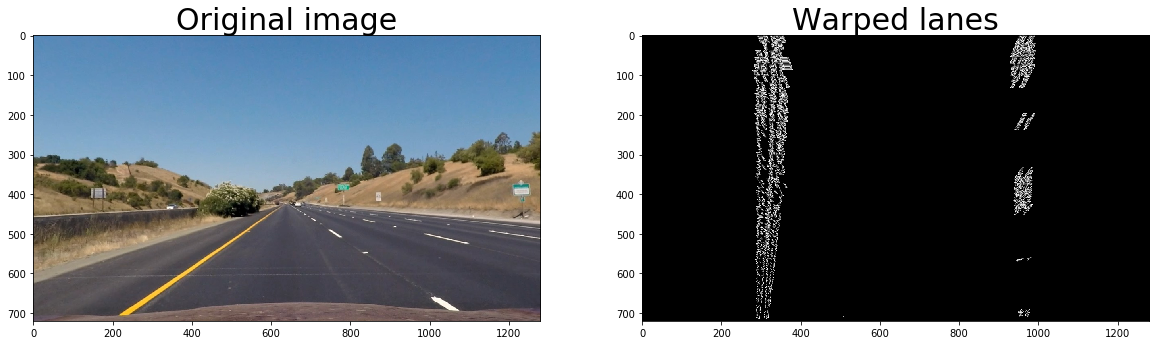

In [9]:
warped = camera.detect_perspective(combined_binary, source_points = [(575, 460), (705, 460), (1127, 720), (203, 720)])

Utils.visualizeBeforeAfter(img,
                           warped,
                           "Original image",
                           "Warped lanes",
                           afterBinary=True)

#### 4. Describe how (and identify where in your code) you identified lane-line pixels and fit their positions with a polynomial?


Then I did some other stuff and fit my lane lines with a 2nd order polynomial kinda like this:

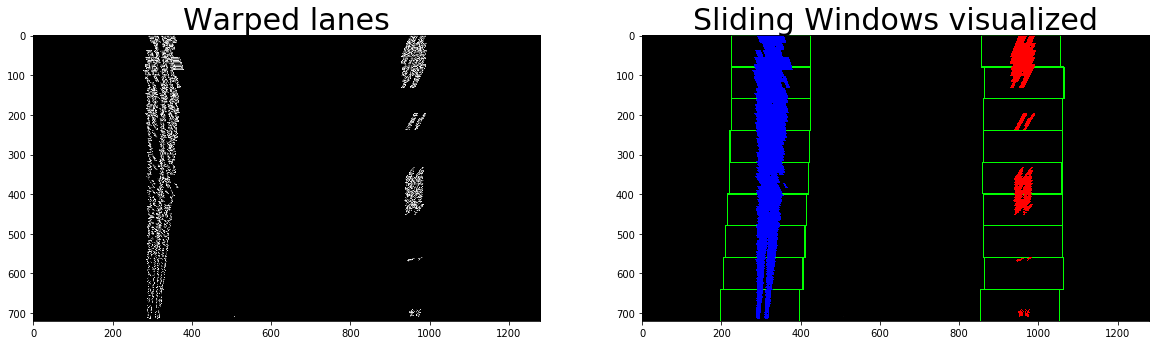

In [10]:
result, left_curverad, right_curverad, off_center = detector.calculate_lane_polynomial_fits(warped, img)
result = cv2.cvtColor(result.astype(np.uint8), cv2.COLOR_RGB2BGR)
Utils.visualizeBeforeAfter(warped,
                           result,
                           "Warped lanes",
                           "Sliding Windows visualized",
                           beforeBinary=True)

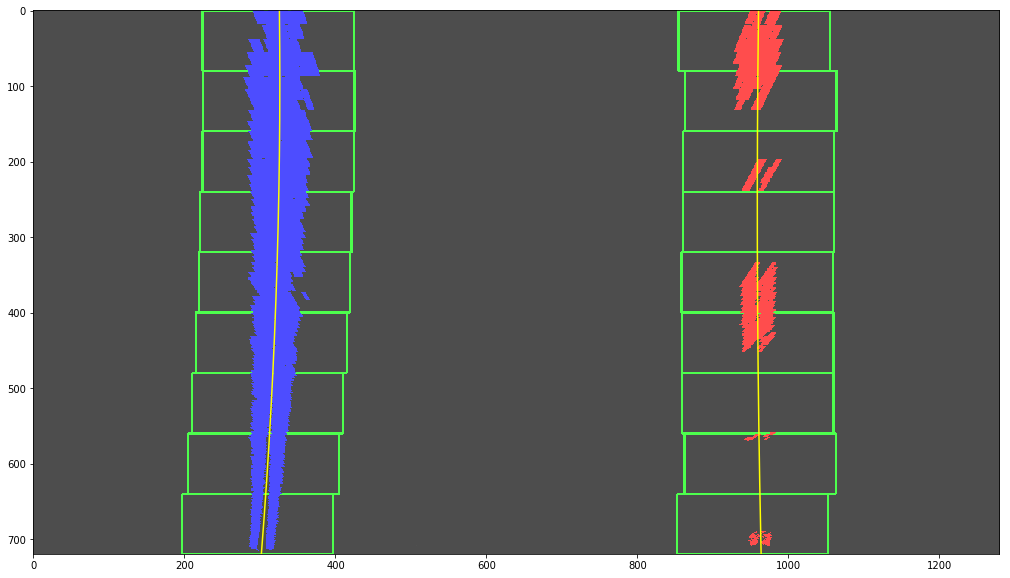

In [11]:
# Display the final results
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(result, alpha=0.7)
ax1.plot(detector.left_fitx, detector.ploty, color='yellow')
ax1.plot(detector.right_fitx, detector.ploty, color='yellow')

#### 5. Describe how (and identify where in your code) you calculated the radius of curvature of the lane and the position of the vehicle with respect to center.

I did this in function `curvature()` in the `Detector` class.


In [12]:
detector.curvature(warped, img)

(2618.452286559047, 6803.7054140527907, 0.042285714285714288)

#### 6. Provide an example image of your result plotted back down onto the road such that the lane area is identified clearly.

I implemented this step in function `reverse_pespective_warped_and_overlay_on_image()` above in the `Camera` class.

Here is an example of my result on a test image:

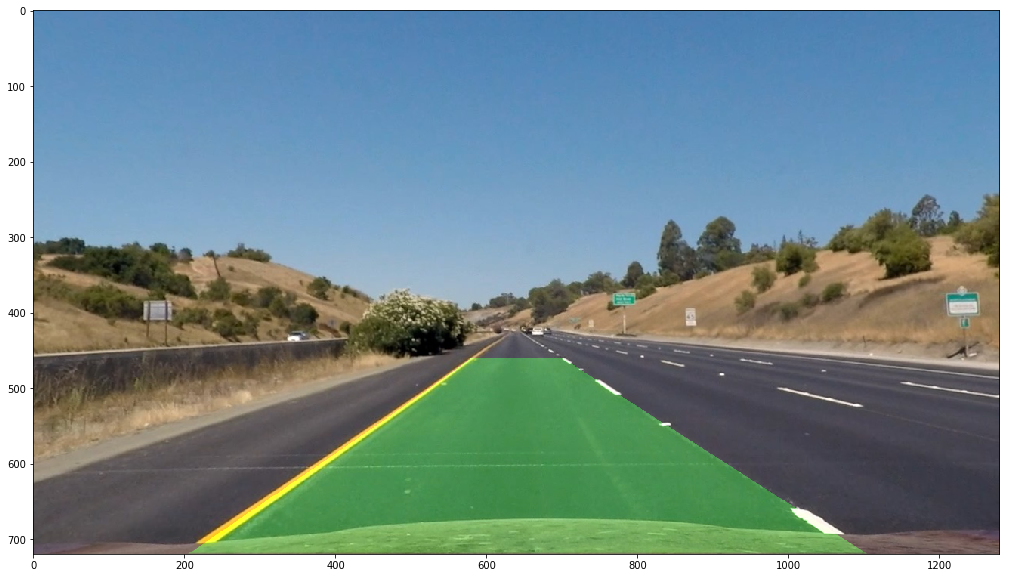

In [13]:
result = camera.reverse_pespective_warped_and_overlay_on_image(detector, warped, img)
f, (ax1) = plt.subplots(1, 1, figsize=(20,10))
ax1.imshow(result)

---

### Pipeline (implementation)


In [14]:
def draw_info(image, left_curverad, right_curverad, off_center):
    cv2.putText(image, "left curvature: %0.1fm" % left_curverad, (0, 40),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
    cv2.putText(image, "right curvature: %0.1fm" % right_curverad, (0, 100),
                cv2.FONT_HERSHEY_SIMPLEX, 1.2, (255, 255, 255), 2)
    cv2.putText(image, "center offset: %0.3fm" % off_center, (0, 160), cv2.FONT_HERSHEY_SIMPLEX, 1.3,
                (255, 255, 255), 2)


def pipeline(undist, image):
    (gradx, grady, mag_binary, dir_binary, color_binary, color_binary2) = binarizer.binarize(image,
                                                                              gradx_thresh=(50, 180),
                                                                              grady_thresh=(50, 210),
                                                                              mag_thresh=(40, 255),
                                                                              dir_thresh=(0.7, 1.3)
                                                                                            )
    combined_binary = binarizer.get_combined_binary(gradx, grady, mag_binary, dir_binary)
#     (sxbinary, s_binary, color_binary) = binarizer.binarize(undist)
#     combined_binary = binarizer.get_combined_binary(s_binary=s_binary, sxbinary=sxbinary)
    warped = camera.detect_perspective(combined_binary, source_points = [(579, 461), (706, 461), (1068, 692), (255, 692)])
    result, left_curverad, right_curverad, off_center = detector.calculate_lane_polynomial_fits(warped, undist)
#     iterative_fit_calculation
    result = camera.reverse_pespective_warped_and_overlay_on_image(detector, warped, undist)
    draw_info(result, left_curverad, right_curverad, off_center)
 
#     result = cv2.addWeighted(result, 1.0, (np.dstack((warped, warped, warped))*255).astype(np.uint8), 0.3, 0)

    return result


In [ ]:
def process_image(image):
    undist = camera.undistort(image)
    result = pipeline(undist, image)
    return result

In [ ]:
# Initialize a new detector
detector = Detector()

from moviepy.editor import VideoFileClip
from IPython.display import HTML
white_output = './project_video_out.mp4'
clip1 = VideoFileClip("./project_video.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False, verbose=False)

 98%|█████████▊| 1242/1261 [09:00<00:06,  2.76it/s]

---

### Pipeline (video)

#### 1. Provide a link to your final video output.  Your pipeline should perform reasonably well on the entire project video (wobbly lines are ok but no catastrophic failures that would cause the car to drive off the road!).


### project_video.mp4

[Click for actual video on youtube](https://youtu.be/mz5xCbOXV8M)

<a href="https://youtu.be/mz5xCbOXV8M"><img src="project_video_out.gif" align="left" width="800" ></a>


---

### Discussion

#### 1. Briefly discuss any problems / issues you faced in your implementation of this project.  Where will your pipeline likely fail?  What could you do to make it more robust?

While I was satisfied with rsults of `project_video.mp4`, but I faced issues in getting any good results on `challenge_video.mp4` and `harder_challenge_video.mp4`.

Pipeline basically failed in following condisions:
1. When the divider is close to the lane line.
2. Sometimes when shadow is inconveniently in the middle of the lane.
3. Sometimes the quality of road is not good. Because of new construction, its common to see the remains of the old lane in the middle of the new lane.
4. Curvy roads (as in harder challenge video)

To make it more robust, I might need to do some adjustments to the coordinates used in perspective transformation.


# Update (after review)
1. Fixed the logic related lane polynomial fitting.
2. One of the functions `find_window_centroids()` was just an extra way of getting centroids, but I am using sliding window method. So removed that code.
3. Added curvature and offset info on frames.
4. Added exponential smoothing as suggested by reviewer.
5. Also add a function `fit_sanity_check()` which keeps track of last 10 coefficients and see if the latest coffecient is deviating too much or not. If it does, then I reuse the last good ceooeficient and set `detection` to False, and after 5 bad detections, we reset the whole thing.
6. After all these improvements, the `project_video_out.mp4` improved considerably, but the challenge and the harder_challenge still werre quite unsatisfactory, hence I removed them from the submission in this report.

